# 2등 송근일, 이유한 코드 분석


참고 코드:<br>
<https://dacon.io/competitions/official/17801/codeshare/442?page=1&dtype=recent&ptype=pub>

<hr>

## 패키지 로드

In [2]:
# 경고 문구 무시
# import warnings
# warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, font_manager
import seaborn as sns
import datetime
import featuretools as ft
# 한글 글자 폰트 설정
rc('font',family="Malgun")

# notebook을 실행한 브라우저에서 바로 그림을 보여준다.
%matplotlib inline

import xgboost as xgb

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.linear_model import LinearRegression

from scipy.stats import uniform, randint
import scipy.stats as st

<br>

## 데이터 로드

In [3]:
train=pd.read_csv("./Auction_master_train.csv")

# 특이하게 값이 너무 크기 때문에 제거해줌.
train=train.loc[train['Auction_key']!=10,]

test=pd.read_csv("./Auction_master_test.csv")
regist=pd.read_csv("./Auction_regist.csv")
rent=pd.read_csv("./Auction_rent.csv")
result=pd.read_csv("./Auction_result.csv")

- IQR에 대해서 공부하기.
- boxplot으로 이상치값 그림으로 확인하기.

In [7]:
#  train.info()
# train.Auction_class.unique()
# train.

array(['낙찰'], dtype=object)

In [42]:
train.head()[['Total_appraisal_price','Minimum_sales_price','Hammer_price']]
# train.addr_etc

Total_appraisal_price  Minimum_sales_price  Hammer_price
0              836000000            668800000     760000000
1             1073000000            858400000     971889999
2              119000000             76160000      93399999
3              288400000            230720000     256899000
4              170000000            136000000     158660000

In [43]:
train.loc[train['Auction_key']==10,]

Empty DataFrame
Columns: [Auction_key, Auction_class, Bid_class, Claim_price, Appraisal_company, Appraisal_date, Auction_count, Auction_miscarriage_count, Total_land_gross_area, Total_land_real_area, Total_land_auction_area, Total_building_area, Total_building_auction_area, Total_appraisal_price, Minimum_sales_price, First_auction_date, Final_auction_date, Final_result, Creditor, addr_do, addr_si, addr_dong, addr_li, addr_san, addr_bunji1, addr_bunji2, addr_etc, Apartment_usage, Preserve_regist_date, Total_floor, Current_floor, Specific, Share_auction_YorN, road_name, road_bunji1, road_bunji2, Close_date, Close_result, point.y, point.x, Hammer_price]
Index: []

[0 rows x 41 columns]

In [44]:
train['Hammer_price'].describe()

count    1.932000e+03
mean     4.650927e+08
std      4.464047e+08
min      6.303000e+06
25%      1.974162e+08
50%      3.539750e+08
75%      5.573050e+08
max      4.863000e+09
Name: Hammer_price, dtype: float64

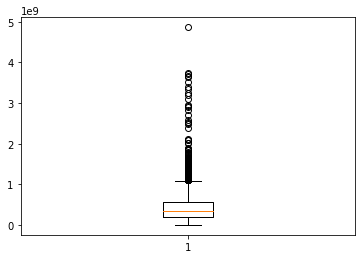

In [45]:
plt.boxplot(train['Hammer_price'])
plt.show()

In [10]:
IQR=362345000
Q3=559900000
out=Q3+3*IQR
out

1646935000

In [46]:
train.corr()['Hammer_price'].sort_values()

Auction_key                   -0.494335
point.x                       -0.357186
Auction_count                 -0.060598
Auction_miscarriage_count     -0.059509
addr_bunji1                   -0.018607
addr_bunji2                    0.000084
road_bunji1                    0.028545
Total_land_gross_area          0.094260
road_bunji2                    0.206681
Claim_price                    0.227550
Current_floor                  0.263951
Total_floor                    0.288378
point.y                        0.357915
Total_land_real_area           0.457389
Total_land_auction_area        0.470488
Total_building_area            0.644298
Total_building_auction_area    0.651966
Total_appraisal_price          0.976729
Minimum_sales_price            0.992170
Hammer_price                   1.000000
Name: Hammer_price, dtype: float64

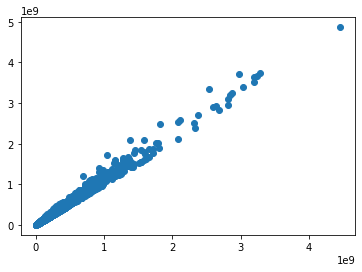

In [47]:
plt.scatter(train['Minimum_sales_price'],train['Hammer_price'])

- target(Hammer_price)와 상관관계의 절대값이 높은 것은 Minimum_sales_price라는 변수.
- 이대로 학습을 진행하면, Minimum_sales_price 에 중요도가 매우 높아져, 다른 feature 들의 정보가 묻힐 가능성이 높다고 생각.
- Hammer_price >= Minimum_sales_price 일 것이므로, Minimum_sales_price 에 대비해 몇 %(ratio) 를 예측하도록 문제를 바꾸고자 한다.
- Hammer_price 는 그 수치의 절대 값이 큰 편이라 variance 가 자연스레 커진다. 하지만 ratio 는 1~2 정도의 수치이므로 variance 가 적기 때문에 좀 더 세밀한 예측을 할 수 있게 된다.
- new_target(real) = Hammer_price/Minimum_sales_price 로 잡고, 예측값에 다시 Minimum_sales_price 를 곱하여 실제 Hammer_price 를 예측하는 방식으로 문제를 재구성했다.

<br>

### real컬럼 만들기

In [4]:
train['real']=train['Hammer_price']/train['Minimum_sales_price']
test['real']=test['Hammer_price']/test['Minimum_sales_price']

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='real', ylabel='Density'>

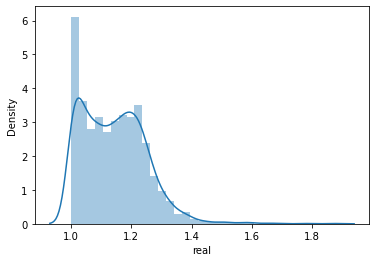

In [49]:
sns.distplot(train['real'])

In [15]:
train.drop(['Hammer_price'],axis=1).corr()['real'].sort_values()

Auction_key                   -0.062983
Current_floor                 -0.055709
Total_floor                   -0.051553
Minimum_sales_price           -0.042232
point.x                       -0.039527
road_bunji1                   -0.021469
addr_bunji2                   -0.002634
Total_land_gross_area          0.006978
addr_bunji1                    0.013455
Total_appraisal_price          0.020108
Total_building_area            0.025305
Total_building_auction_area    0.027848
point.y                        0.038295
road_bunji2                    0.047078
Total_land_real_area           0.059067
Total_land_auction_area        0.060240
Claim_price                    0.104271
Auction_count                  0.356021
Auction_miscarriage_count      0.381825
real                           1.000000
Name: real, dtype: float64

- 낙찰가 삭제

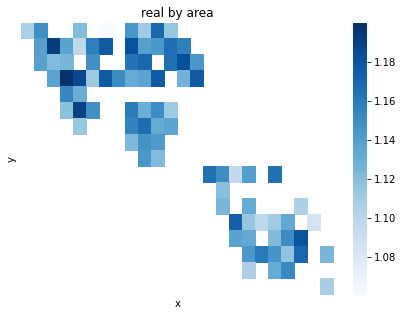

In [62]:
cop=train.copy()
cop['x']=pd.cut(train['point.x'],100)
cop['y']=pd.cut(train['point.y'],100)
cop1=cop.groupby(['x','y']).size().reset_index(name='count')
cop2=cop.groupby(['x','y'])['real'].mean().reset_index(name='real')
cop=pd.merge(cop1,cop2,on=['x','y'],how='left')

cop=cop.loc[cop['count']>=9]
area = cop.pivot("y", "x", "real")
plt.subplots(1, 1, figsize=(7, 5))
plt.title("real by area")
sns.heatmap(area, annot=False, xticklabels=False,yticklabels=False,cmap="Blues")
plt.show()

- 위도와 경도를 100개로 나누어서(cut) 각 grid 안의 real 값을 평균을 내서 heatmap으로 그려 보았다.(단 각 grid 안에 object가 9개 이상인 grid들만 뽑았다) 
- 예상외로 지역별 real값의 차이가 있어 보인다. 
- 범위를 많이 좁히고, 세밀하게 예측하기 위해 'addr_dong'이라는 변수를 모델에 포함시키면 좋겠다(물론 point.x와 point.y도 있지만 그걸로는 부족해 보인다)

In [51]:
# nuique : unique한 값의 개수
train['addr_dong'].nunique()

285

- addr_dong은 총 285개의 unique한 값들을 가지고 있고, 그에 비해 우리가 가지고 있는 데이터셋은 너무 적다 (데이터셋이 좀 더 크면 catboost같이 범주형 데이터를 잘 다루어주는 모델도 사용해보았을 것이다)
- 위치적인 요소들을 고려해줄 수 있는 외부데이터가 필요해 보인다.
- 이번에는 각각 1.close_date과 final_auction_date, 2.first_auction_date과 appraisal_date, 3.final_auction_date과 first_auction_date간의 차이(날 차이)를 변수로 만들어 보았다.

In [5]:
# errors='coerce'  :  문자가 포함되어 있는 경우는 강제로 'NaN'으 값으로 변환하고, 나머지 숫자로된 문자열은 숫자형으로 변환
train['daydiff1']=(pd.to_datetime(train['Close_date'],errors='coerce') - pd.to_datetime(train['Final_auction_date'],errors='coerce')).dt.days
# 결측값은 평균으로 대체
train['daydiff1']=np.where(train['daydiff1'].isnull(),train['daydiff1'].mean(),train['daydiff1'])

train['daydiff']=(pd.to_datetime(train['First_auction_date'],errors='coerce') - pd.to_datetime(train['Appraisal_date'],errors='coerce')).dt.days

# 음수는 중앙값으로 대체
train['daydiff']=np.where(train['daydiff']<0,train['daydiff'].median(),train['daydiff'])
train['daydiff2']=(pd.to_datetime(train['Final_auction_date'],errors='coerce')-pd.to_datetime(train['First_auction_date'],errors='coerce')).dt.days

In [40]:
train[train['daydiff']<0]

Empty DataFrame
Columns: [Auction_key, Auction_class, Bid_class, Claim_price, Appraisal_company, Appraisal_date, Auction_count, Auction_miscarriage_count, Total_land_gross_area, Total_land_real_area, Total_land_auction_area, Total_building_area, Total_building_auction_area, Total_appraisal_price, Minimum_sales_price, First_auction_date, Final_auction_date, Final_result, Creditor, addr_do, addr_si, addr_dong, addr_li, addr_san, addr_bunji1, addr_bunji2, addr_etc, Apartment_usage, Preserve_regist_date, Total_floor, Current_floor, Specific, Share_auction_YorN, road_name, road_bunji1, road_bunji2, Close_date, Close_result, point.y, point.x, Hammer_price, real, daydiff1, daydiff, daydiff2, built_date, built_date1, falld, lastupp, upp, lastupp_p, one, apart, cred, take_over_rent, take_over_regist, take_over_sum, badang, is_rent, is_regist, floor_rate, is_re]
Index: []

[0 rows x 62 columns]

In [6]:
test['daydiff1']=(pd.to_datetime(test['Close_date'],errors='coerce') - pd.to_datetime(test['Final_auction_date'],errors='coerce')).dt.days
test['daydiff1']=np.where(test['daydiff1'].isnull(),test['daydiff1'].mean(),test['daydiff1'])

test['daydiff']=(pd.to_datetime(test['First_auction_date'],errors='coerce') - pd.to_datetime(test['Appraisal_date'],errors='coerce')).dt.days

test['daydiff']=np.where(test['daydiff']<0,test['daydiff'].median(),test['daydiff'])
test['daydiff2']=(pd.to_datetime(test['Final_auction_date'],errors='coerce') - pd.to_datetime(test['First_auction_date'],errors='coerce')).dt.days

In [7]:
#Regist_date(임차일)을 datetime 형태로 변환
# regist['Regist_date']=pd.to_datetime(regist['Regist_date'].astype('str').str.slice(0,4)+"-"+regist['Regist_date'].astype('str').str.slice(4,6)+"-"+regist['Regist_date'].astype('str').str.slice(6,8),errors='coerce')
# regist['Regist_date']

# 이 방법이 더 간단
regist['Regist_date']=pd.to_datetime(regist['Regist_date'],format='%Y%m%d',errors='coerce')
regist['Regist_date']

0       2005-07-15
1       2005-09-14
2       2005-12-29
3       2006-04-28
4       2007-04-10
           ...    
20697   2016-07-25
20698   2016-08-29
20699   2016-10-28
20700   2017-07-17
20701   2011-04-18
Name: Regist_date, Length: 20702, dtype: datetime64[ns]

In [8]:
#Auction_date와 Rent_date를 datetime 형태로 변환
result['Auction_date']=pd.to_datetime(result['Auction_date'])
rent['Rent_date']=pd.to_datetime(rent['Rent_date'],errors='coerce')

In [9]:
#regist(등기부등본)에 써져 있는 등기 중 가장 일찍 등기된 것을 고른다 ==&gt; 가장 일찍 등기된 날짜가 건설작업완료 날짜의 추정치이다.
train['built_date']=train.apply(lambda x: regist.loc[(regist['Auction_key']==x['Auction_key']),"Regist_date"].min(),axis=1)
train['built_date']=pd.DatetimeIndex(train['built_date']).year
train['built_date']=np.where(train['built_date'].isnull(),train['built_date'].median(),train['built_date'])

#built_date이라는 변수는 건설작업완료 추정 년도를, built_date는 그 년도가 2000년을 넘기는지 아닌지를 가르키는 변수이다.
train['built_date1']=train['built_date']<=2000



test['built_date']=test.apply(lambda x: regist.loc[(regist['Auction_key']==x['Auction_key']),"Regist_date"].min(),axis=1)
test['built_date']=pd.DatetimeIndex(test['built_date']).year
test['built_date']=np.where(test['built_date'].isnull(),test['built_date'].median(),test['built_date'])

test['built_date1']=test['built_date']<=2000

- 우리는 Hammer_price/Minimum_price를 타겟으로 놓고 모델을 training시킬 것이므로, Minimum_sales_price나 Total_appraisal_price같이 그냥 단순 금액치보다는 비율적인 정보가 더 중요하다. 그래서 일단 falld(Minimum_sales_price/Total_appraisal_price)라는 변수를 만든다. 그리고 최저경매가가 유찰이 진행될 수록 감정가의 80% ,64% ,51.2%,41%,32.8%, 26.2%, 21%, 16.8%, 13.4% 이런 식으로 떨어지기 때문에 lastupp, 낙찰되기 직전의 유찰된 경매에서의 Minimum_sales_price / Total_appraisal_price,이라는 변수를 생성한다.

- 예를 들어 감정 평가액이 10억이고 4번 유찰되어 최저경매가가 4.1억이면, falld는 4.1억/10억==0.41이 될 것이고, 낙찰되기 이전, 즉 3번 유찰되었던 시점에 최저경매가는 5.12억이므로 lastupp은 5.21/10==0.521이 될 것이다.

- upp은 lastupp/falld를 한 것이고, lastupp_p는 lastupp에서 Total_appraisal_price를 곱한 값이다.

- 이렇게 단순금액보다는 비율적인 요소를 더 잘 나타낼 수 있는 변수들을 집중적으로 생성해내었고 모델의 정확도 상승에도 큰 도움을 주었다.

In [10]:
train['falld']=(train['Minimum_sales_price']/train['Total_appraisal_price']).round(3)

a=pd.Series([0.134,0.168,0.21,0.262,0.328,0.41,0.512,0.64,0.8,1,1])
b=pd.Series([0,0.134,0.168,0.21,0.262,0.328,0.41,0.512,0.64,0.8,1,1])

train['lastupp']=train.apply(lambda x : a[b==x['falld']].iloc[0],axis=1)

test['falld']=(test['Minimum_sales_price']/test['Total_appraisal_price']).round(3)

a=pd.Series([0.134,0.168,0.21,0.262,0.328,0.41,0.512,0.64,0.8,1,1])
b=pd.Series([0,0.134,0.168,0.21,0.262,0.328,0.41,0.512,0.64,0.8,1,1])

test['lastupp']=test.apply(lambda x : a[b==x['falld']].iloc[0],axis=1)

train['upp']=train['lastupp']/train['falld']
test['upp']=test['lastupp']/test['falld']

train['lastupp_p']=train['lastupp']*train['Total_appraisal_price']
test['lastupp_p']=test['lastupp']*test['Total_appraisal_price']

In [11]:
train['one']=train['Auction_miscarriage_count']==0
test['one']=test['Auction_miscarriage_count']==0

- 유찰횟수가 0인 값들을 True로 one변수에 추가

In [12]:
apartname=pd.Series(["더샵","자이","아이파크","래미안","힐스테이트"])

In [13]:
apartname=["더샵","자이","아이파크","래미안","힐스테이트"]

train['apart']='others'
for x in apartname:
    train.loc[train['addr_etc'].str.contains(x),'apart'] = x
    
    
test['apart']='others'
for x in apartname:
    test.loc[test['addr_etc'].str.contains(x),'apart'] = x
    
train['apart']
        

0       others
1       others
2       others
3       others
4       others
         ...  
1928    others
1929    others
1930    others
1931       래미안
1932        자이
Name: apart, Length: 1932, dtype: object

In [26]:
# def get_apartname(string_val,apartname):
#     if apartname.apply(lambda x: [x in y for y in [string_val]][0]).sum()>0:
#         return np.asscalar(apartname.loc[apartname.apply(lambda x: [x in y for y in [string_val]][0])])
#     else:
#         return "other"

In [27]:
# train['apart']=train.apply(lambda x: get_apartname(string_val=x['addr_etc'],apartname=apartname),axis=1)
# test['apart']=test.apply(lambda x: get_apartname(string_val=x['addr_etc'],apartname=apartname),axis=1)

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  This is separate from the ipykernel package so we can avoid doing imports until


- 아파트의 브랜드가치도 경매시장에 영향을 줄 수 있을 것이다. 우리나라 대표 아파트 브랜드 5곳(더샵, 자이, 아이파크, 래미안, 힐스테이트)을 뽑아서 addr_etc에서 이 단어의 포함유무를 통해 아파트의 브랜드 변수(apart)를 만든다. 만약 위의 5가지 중 어느 곳에도 포함되어 있지 않는다면 other도 대체한다.

In [14]:
namecred=pd.Series(train['Creditor'].value_counts().head().index.tolist())
namecred

0    Private
1       국민은행
2       우리은행
3     중소기업은행
4       하나은행
dtype: object

In [105]:
# def getcred(string_val,namecred):
#     if namecred.isin([string_val]).sum()>0:
#         return np.asscalar(namecred.loc[namecred.isin([string_val])])
#     else:
#         return "other"
        
# train['cred']=train.apply(lambda x: getcred(x['Creditor'],namecred=namecred),axis=1)
# test['cred']=test.apply(lambda x: getcred(x['Creditor'],namecred=namecred),axis=1)

AttributeError: 'list' object has no attribute 'isin'

In [15]:
namecred=list(namecred)

train['cred']='other'
for x in namecred:
    train.loc[train['Creditor'].str.contains(x),'cred'] = x
    

train[['Creditor','cred']]


# version2
# def find_cred(data,cred):
#     for c in cred:
#         if c in data:
#             return c
#         else:
#             continue
#     return 'other'
        
        
        
# train['cred']=train.apply(lambda x: find_cred(data=x['Creditor'],cred=namecred),axis=1)
# train[['Creditor','cred']]


Creditor     cred
0     베리타스자산관리대부    other
1         흥국저축은행    other
2           국민은행     국민은행
3         고려저축은행    other
4        Private  Private
...          ...      ...
1928     Private  Private
1929      중소기업은행   중소기업은행
1930        우리은행     우리은행
1931     Private  Private
1932     Private  Private

[1932 rows x 2 columns]

In [30]:
rent['Rent_class'].unique()

array(['전입    ', '점유    '], dtype=object)

In [31]:
regist['Regist_class'].unique()

array(['소유이전', '가압    ', '가처분  ', '강제    ', '        ', '임의    ',
       '압류    ', '저당    ', '질권    ', '가등기  ', '보전처분', '이전    ', '전세권  ',
       '임차권  ', '예고등기'], dtype=object)

In [16]:
#경매에서 권리의 인수여부는 말소기준권리를 기준으로 결정된다.
#말소기준권리는 저당,압류, 가압 중에서 가장 먼저 일어난 것이며, 각각의 Auction_key마다 이것을 찾아 malsogijun이라는 데이터프레임을 만들었다.
regist['Regist_class']=regist['Regist_class'].str.replace(pat=" ",repl="")
rent['Rent_class']=rent['Rent_class'].str.replace(pat=" ",repl="")
rent['Rent_date']=pd.to_datetime(rent['Rent_date'],errors='coerce')

malsogijun=regist.loc[pd.Series(regist['Regist_class']).isin(["저당","압류","가압"]),].groupby(['Auction_key'])['Regist_date'].min().reset_index()
malsogijun

Auction_key Regist_date
0               1  2005-09-14
1               3  2005-09-14
2               5  2002-07-29
3               6  2011-03-31
4               7  2011-06-13
...           ...         ...
2624         2758  2015-07-23
2625         2759  2012-03-21
2626         2760  2014-02-25
2627         2761  2006-12-04
2628         2762  2011-04-18

[2629 rows x 2 columns]

In [27]:
rent.loc[rent['Rent_class']=='전입','Rent_date'].unique()
# rent.Rent_class.unique()
# rent[rent['Rent_class']=='점유'].groupby(['Auctiuon_key']).size()>=2

array(['2007-09-14T00:00:00.000000000', '2008-06-27T00:00:00.000000000',
       '2007-01-08T00:00:00.000000000', ...,
       '2009-05-29T00:00:00.000000000', '2007-05-10T00:00:00.000000000',
       '2007-01-18T00:00:00.000000000'], dtype='datetime64[ns]')

In [28]:
#이 말소기준보다 전에 일어나고 점유하고 있는 임차인(대항력을 가진 임차인)을 찾아 해당 경매의 낙찰자가 인수해야 할 Rent_deposit을 take_over_rent라는 변수에 저장한다
def get_rent_malso(Rent_date,Auction_key,Rent_class):
    #if pd.isnull(Rent_date) or len((malsogijun.loc[malsogijun['Auction_key']==Auction_key,"Regist_date"]))==0:
    #    return np.nan
    #else:
    return (#np.asscalar((Rent_date&lt;malsogijun.loc[malsogijun['Auction_key']==Auction_key,"Regist_date"]).values) &
                           (Rent_class=="점유"))


k = rent.loc[rent['Rent_class']=='점유',].groupby(['Auctiuon_key'])['Rent_deposit'].sum().reset_index()
    


k=rent.apply(lambda x: get_rent_malso(Rent_date=x['Rent_date'],Auction_key=x['Auctiuon_key'],Rent_class=x['Rent_class']),axis=1)

rent['k']=k
k=rent.loc[rent['k']==True,].groupby(['Auctiuon_key'])['Rent_deposit'].sum().reset_index()
k.columns=['Auction_key','take_over_rent']
train=pd.merge(train,k,how='left')
test=pd.merge(test,k,how='left')

train['take_over_rent']=np.where(train['take_over_rent'].isnull(),0,train['take_over_rent'])
test['take_over_rent']=np.where(test['take_over_rent'].isnull(),0,test['take_over_rent'])

In [17]:
# 이 말소기준보다 전에 일어나고 점유하고 있는 임차인(대항력을 가진 임차인)을 찾아 해당 경매의 낙찰자가 인수해야 할 Rent_deposit을 
# take_over_rent라는 변수에 저장한다
def get_rent_malso(Rent_date,Auction_key,Rent_class):
    if pd.isnull(Rent_date) or len((malsogijun.loc[malsogijun['Auction_key']==Auction_key,"Regist_date"]))==0:
        return np.nan
    else:
        return (np.asscalar((Rent_date<malsogijun.loc[malsogijun['Auction_key']==Auction_key,"Regist_date"]).values) &
                (Rent_class=="점유"))



k=rent.apply(lambda x: get_rent_malso(Rent_date=x['Rent_date'],Auction_key=x['Auctiuon_key'],Rent_class=x['Rent_class']),axis=1)

rent['k']=k
k=rent.loc[rent['k']==True,].groupby(['Auctiuon_key'])['Rent_deposit'].sum().reset_index()
k.columns=['Auction_key','take_over_rent']
train=pd.merge(train,k,how='left')
test=pd.merge(test,k,how='left')

train['take_over_rent']=np.where(train['take_over_rent'].isnull(),0,train['take_over_rent'])
test['take_over_rent']=np.where(test['take_over_rent'].isnull(),0,test['take_over_rent'])

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  import sys
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  import sys


ValueError: can only convert an array of size 1 to a Python scalar

In [30]:
regist[regist['Regist_date'].isnull()]

Auction_key  Auction_seq Regist_type Regist_class Regist_date Creditor  \
8                1        19992      토지별도등기                      NaT  Private   
9                2        19992      토지별도등기                      NaT  Private   
18               3        19992      토지별도등기                      NaT  Private   
128             15        19992      토지별도등기                      NaT  Private   
191             21        19992      토지별도등기                      NaT  Private   
...            ...          ...         ...          ...         ...      ...   
19119         2545        19995        기타등기                      NaT  Private   
19402         2593        19994        기타등기                      NaT  Private   
19672         2630        19992      토지별도등기                      NaT  Private   
19826         2652        19992      토지별도등기                      NaT  Private   
20401         2719        19992      토지별도등기                      NaT  Private   

       Regist_price  
8                 0  
9                 0  
18                0  
128               0  
191               0  
...             ...  
19119             0  
19402             0  
19672             0  
19826             0  
20401             0  

[162 rows x 7 columns]

In [31]:
#등기부등본 상에서도 말소기준 권리 이전에 일어난 모든 권리행위의 Regist_price를 더해 take_over_regist라는 변수를 만든다.
def get_regist_malso(Regist_date,Auction_key,Regist_class):
        condition={"전세권","임차권","가등기"}
        if pd.isnull(Regist_date) or len((malsogijun.loc[malsogijun['Auction_key']==Auction_key,"Regist_date"]))==0:
            return np.nan
        else:
            return (Regist_date<(malsogijun.loc[malsogijun['Auction_key']==Auction_key,"Regist_date"].values[0])) &\
                           (Regist_class in condition)

        
        
k=regist.apply(lambda x: get_regist_malso(Regist_date=x['Regist_date'],Auction_key=x['Auction_key'],Regist_class=x['Regist_class']),axis=1)
# print(k)

# k=regist.apply(lambda x: get_regist_malso(Regist_date=x['Regist_date'],Auction_key=x['Auction_key'],Regist_class=x['Regist_class']),axis=1)

regist['k']=k
k=regist.loc[regist['k']==True,].groupby(['Auction_key'])['Regist_price'].sum().reset_index()
k.columns=['Auction_key','take_over_regist']
train=pd.merge(train,k,how='left')
test=pd.merge(test,k,how='left')

train['take_over_regist']=np.where(train['take_over_regist'].isnull(),0,train['take_over_regist'])
test['take_over_regist']=np.where(test['take_over_regist'].isnull(),0,test['take_over_regist'])

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
C:\Users\Minyoung Kim\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.

In [41]:
train['take_over_regist'].value_counts()

0.000000e+00    1908
1.600000e+08       2
7.500000e+07       2
2.300000e+08       2
1.000000e+08       2
7.000000e+07       1
1.500000e+08       1
3.790000e+07       1
4.000000e+07       1
2.300000e+09       1
1.800000e+08       1
5.200000e+08       1
6.000000e+07       1
7.800000e+07       1
5.500000e+07       1
6.500000e+06       1
3.000000e+07       1
1.400000e+09       1
9.000000e+07       1
5.000000e+08       1
4.200000e+08       1
Name: take_over_regist, dtype: int64

In [32]:
train['take_over_sum']=train['take_over_regist']+train['take_over_rent']
test['take_over_sum']=test['take_over_regist']+test['take_over_rent']

In [35]:
a=regist.apply(lambda x: pd.Series(x['Regist_class']).isin(['전세권','가등기','임차권']),axis=1)
a.columns=['a']


regist1=regist.loc[a['a'],]

def get_badang(Auction_key,a=regist1):
    return len(a.loc[a['Auction_key']==Auction_key,])
    
train['badang']=train.apply(lambda x: get_badang(x['Auction_key'],a=regist1),axis=1)
test['badang']=test.apply(lambda x: get_badang(x['Auction_key'],a=regist1),axis=1)

In [39]:
# train['badang'].unique()
test['badang'].unique()

array([0, 1, 2, 3], dtype=int64)

- 등기부등본(regist) 상의 전세권, 가등기, 임차권을 가지고 있는 사람의 명수를 더해 badang이라는 변수에 저장한다. 이 변수는 낙찰이 되었을 때 해당 금액을 배당받을 수 있는 사람들의 명수를 의미한다.

In [40]:
train['is_rent']=train.apply(lambda x: pd.Series(x['Auction_key']).isin(list(rent['Auctiuon_key'])),axis=1)
test['is_rent']=test.apply(lambda x: pd.Series(x['Auction_key']).isin(list(rent['Auctiuon_key'])),axis=1)
train['is_regist']=train.apply(lambda x: pd.Series(x['Auction_key']).isin(list(regist['Auction_key'])),axis=1)
test['is_regist']=test.apply(lambda x: pd.Series(x['Auction_key']).isin(list(regist['Auction_key'])),axis=1)

In [38]:
#regist나 rent에 대한 정보가 있는 것이 오히려 real값이 적어지는 경향이 있는 것을 알 수 있다.
train['floor_rate']=train['Current_floor']/train['Total_floor']
test['floor_rate']=test['Current_floor']/test['Total_floor']

- 해당 방의 층을 아파트의 전체 층으로 나눈 층의 비율을 floor_rate 라는 변수로 만듦.
- 아파트마다 층이 다르므로, 이를 비교하기위한 normalization 과정이라 할 수 있다.

In [39]:
result1=result.loc[result['Auction_results']=="낙찰",]

a=result1.groupby(['Auction_key'])['Auction_results'].count().reset_index()
a['Auction_results']=a['Auction_results']>1
a.columns=['Auction_key','is_re']
train=pd.merge(train,a,how='left')
test=pd.merge(test,a,how='left')

- 낙찰이 한 번 되었다고 해도 낙찰자가 돈을 못 내서 경매가 다시 일어나는 경우가 있다. 유찰과 다르게 이것을 재경매라고 부르는데, result라는 데이터프레임에서, 하나의 Auction_key당 Auction_results가 2개 이상 있을 때 재경매라고 할 수 있을 것이다. 이렇게 재경매가 일어난 경매를 is_re라는 변수로 구분한다.

In [43]:
a

a
0      False
1      False
2      False
3      False
4      False
...      ...
20697  False
20698  False
20699  False
20700  False
20701  False

[20702 rows x 1 columns]

In [44]:
from tqdm import tqdm

result_df = pd.DataFrame()
for i, df in tqdm(result.groupby('Auction_key')):
    result_df.loc[i, 'Auction_key'] = int(df['Auction_key'].values[0])
    result_df.loc[i, 'nac'] = (df['Auction_results'] == '낙찰').sum()
    result_df.loc[i, 'bae'] = (df['Auction_results'] == '배당').sum()
    result_df.loc[i, 'you'] = (df['Auction_results'] == '유찰').sum()
    result_df.loc[i, 'byun'] = (df['Auction_results'] == '변경').sum()
    result_df.loc[i, 'dae'] = (df['Auction_results'] == '대납').sum()
    result_df.loc[i, 'nacrat'] = (df['Auction_results'] == '낙찰').mean()
    result_df.loc[i, 'baerat'] = (df['Auction_results'] == '배당').mean()
    result_df.loc[i, 'yourat'] = (df['Auction_results'] == '유찰').mean()
    result_df.loc[i, 'byunrat'] = (df['Auction_results'] == '변경').mean()
    result_df.loc[i, 'daerat'] = (df['Auction_results'] == '대납').mean()
    result_df.loc[i, 'maxres'] = df['Auction_results'].value_counts().index[0]
    result_df.loc[i, 'maxnum'] = df['Auction_results'].value_counts()[0]
    result_df.loc[i, 'maxrat'] = (df['Auction_results'].value_counts()/df['Auction_results'].value_counts().sum())[0]

100%|██████████████████████████████████████████████████████████████████████████████| 2762/2762 [02:57<00:00, 15.58it/s]


In [ ]:
train = train.merge(result_df, how='left', on='Auction_key')
test = test.merge(result_df, how='left', on='Auction_key')

In [ ]:
def get_trend(x,data):
    y=pd.DatetimeIndex(data['Final_auction_date']).year[x]
    m=pd.DatetimeIndex(data['Final_auction_date']).month[x]-1
    
    if m&lt;=0:
        y=pd.DatetimeIndex(data['Final_auction_date']).year[x]-1
        m=12
    
    y1=pd.DatetimeIndex(data['Final_auction_date']).year[x]
    m1=pd.DatetimeIndex(data['Final_auction_date']).month[x]

    if data['addr_do'].iloc[x]=="부산":
        k=busan
    else:
        k=seoul
    
    k=k[['Unnamed: 0',data['addr_si'].iloc[x]]]
    
    result1=k.loc[  (pd.DatetimeIndex(k['Unnamed: 0']).year==y1) & 
                    (pd.DatetimeIndex(k['Unnamed: 0']).month==m1),data['addr_si'].iloc[x]  ]
        
    result2=k.loc[  (pd.DatetimeIndex(k['Unnamed: 0']).year==y) & 
                    (pd.DatetimeIndex(k['Unnamed: 0']).month==m),data['addr_si'].iloc[x]  ]      

    return np.asscalar(result1)/np.asscalar(result2)

In [ ]:
train['trend']=train.apply(lambda x: get_trend(x.name,data=train),axis=1)
test['trend']=test.apply(lambda x: get_trend(x.name,data=test),axis=1)

- 낙찰가에 영향을 미치는 요소는 낙찰시점 시세뿐 아니라, 해당 아파트가 속한 구의 아파트 가격의 추세도 중요한 요소가 될 수 있다. 예를 들어 해당 구의 가격이 엄청나게 빨리 뛰고 있으면 해당 아파트를 소유하는 것이(낙찰받는 것이) 미래가치가 높을 것이라고 사람들이 판단할 것이고 자연스레 낙찰가는 상승하는 효과를 보일 것이다. 그래서 이 요소를 trend라는 변수로 저장한다.trend는 (낙찰시점 시세)/(낙찰시점 한달 전의 시세)로 계산한다.